In [2]:
%matplotlib inline
#%matplotlib widget

In [34]:
#############imports######################################################################
import cv2 as cv2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import trackpy as tp
import scipy as sc
import matplotlib.colors as colors
import os
from ipywidgets import HBox, Textarea, interact

In [35]:
def read_time(time_value):
    fps=25
    sign_index=time_value.index(':')
    minutes=int(time_value[0:sign_index])
    sec=int(time_value[sign_index+1:len(time_value)])
    frames=(minutes*60+sec)*25
    return frames
#def expShift(t,A,tau,k):
#    return A*np.exp(-t/tau)+k
def expShift(t,A,tau,k):
    return A*np.exp(-(t**2)/((tau**2)))+k
#def CovToCorr(cov_data):
#    shape=cov_data.shape
#    result=[]
#    for i in range(0,shape):
def powerlaw(x,A,n):
    return A*x**n
def linear_fit_log(x,n,A):
    return n*x+A

In [118]:
passive_path='C:\\Users\\User\\Documents\\Eden\\locate_git_code\\packaged\\all_linking_passive_data_28cm.csv'
#expSumFileNamePassive='C:\\Users\\User\\Documents\\Eden\\locate_git_code\\packaged\\expSumPack_botnum_28cm_updated.csv'
#expSumPassive=pd.read_csv(expSumFileNamePassive,index_col=0)
passive_path_packaged='C:\\Users\\User\\Documents\\Eden\\locate_git_code\\packaged'
Passive_path_table=pd.read_csv(passive_path,index_col=0)
emsd_data=pd.DataFrame()
bottypes=['fronter','aligner']
botnums=[1,4,8,16,21,53]
#rerelevant_data=Passive_path_table.loc[bottype,diameter]
for botnum in botnums:
    for bottype in bottypes:
        
        relevant_data=Passive_path_table[(Passive_path_table['BotNum']==botnum)&(Passive_path_table['BotType']==bottype)]
        filenames=pd.unique(relevant_data['Filename'])
        particle=0
        for filename in filenames:
            if ((filename=='updated_test_fronter_N001_D028_C0553.MP4_link.csv')|(filename=='updated_test_fronter_N001_D028_C0554.MP4_link.csv')|(filename=='aligner_N001_D028_C0572.MP4_link.csv')):
                continue
            print(filename)
            emsd_file_data=relevant_data[(relevant_data['Filename']==filename)]
            emsd_file_data=emsd_file_data.iloc[:,0:4]
            emsd_file_data['Filename']=[filename]*len(emsd_file_data)
            emsd_file_data['particle']=[particle]*len(emsd_file_data)
            emsd_file_data['BotNum']=[botnum]*len(emsd_file_data)
            emsd_file_data['BotType']=[bottype]*len(emsd_file_data)
            emsd_data=pd.concat([emsd_data,emsd_file_data],axis=0,ignore_index=True)
            particle=(particle+1)
print(emsd_data)

fronter_N001_D028_C0556.MP4_link.csv
fronter_N001_D028_C0555.MP4_link.csv
aligner_N001_D028_C0575.MP4_link.csv
aligner_N001_D028_C0574.MP4_link.csv
aligner_N001_D028_C0573.MP4_link.csv
fronter_N004_D028_C0560.MP4_link.csv
fronter_N004_D028_C0559.MP4_link.csv
fronter_N004_D028_C0558.MP4_link.csv
fronter_N004_D028_C0557.MP4_link.csv
aligner_N004_D028_C0580.MP4_link.csv
aligner_N004_D028_C0579.MP4_link.csv
aligner_N004_D028_C0578.MP4_link.csv
aligner_N004_D028_C0577.MP4_link.csv
aligner_N004_D028_C0576.MP4_link.csv
fronter_N008_D028_C0567.MP4_link.csv
fronter_N008_D028_C0566.MP4_link.csv
fronter_N008_D028_C0565.MP4_link.csv
fronter_N008_D028_C0563.MP4_link.csv
fronter_N008_D028_C0562.MP4_link.csv
aligner_N008_D028_C0587.MP4_link.csv
aligner_N008_D028_C0586.MP4_link.csv
aligner_N008_D028_C0585.MP4_link.csv
aligner_N008_D028_C0584.MP4_link.csv
aligner_N008_D028_C0583.MP4_link.csv
updated_test_aligner_N008_D028_C0581.MP4_link.csv
fronter_N016_D028_C0571.MP4_link.csv
fronter_N016_D028_C0570.M

[ 1.37917202 -3.29705541]
[0.00298224 0.00996924]


C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized


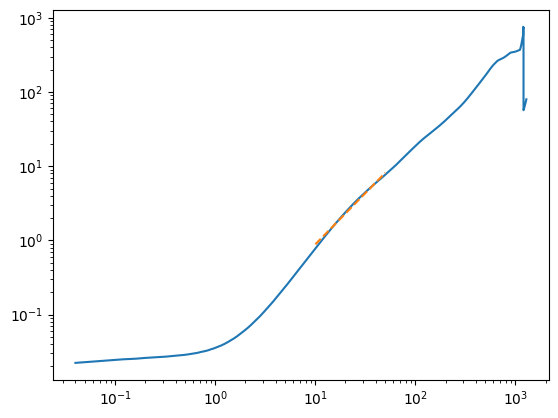

In [119]:
arenaSizePixels = 1080 # [pixels]
arenaSizeCm = 150 # [cm]
fps =25
mpp = arenaSizeCm/arenaSizePixels#/2 #[cm/pixel]
bottype='aligner'
botnum=1
relevant_emsd=emsd_data[(emsd_data['BotNum']==botnum)&(emsd_data['BotType']==bottype)]
#print(relevant_emsd)
emsd_data_filtered = tp.filter_stubs(relevant_emsd,threshold=100)
max_lagtime=int(len(emsd_data_filtered)/3)
emsd=tp.emsd(emsd_data_filtered,fps=fps,mpp=mpp,max_lagtime=max_lagtime)
#emsd_small_range=emsd.loc[4:100]
emsd_small_range=emsd.loc[10:50]
p0=np.array([2,0.5])
popt,pcov = sc.optimize.curve_fit(linear_fit_log,np.log(emsd_small_range.index),np.log(emsd_small_range),p0=p0)
perr = np.sqrt(np.diag(pcov))
corr=np.corrcoef(pcov,rowvar=True)
print(popt)
print(perr)
fig, ax = plt.subplots()
ax.plot(emsd.index, emsd)
ax.set_xscale('log')
ax.set_yscale('log')
fit_x=np.log(emsd_small_range.index)
fit_y=fit_x*popt[0]+popt[1]
ax.loglog(np.exp(fit_x),np.exp(fit_y),'--')

In [120]:
arenaSizePixels = 1080 # [pixels]
arenaSizeCm = 150 # [cm]
fps =25
mpp = arenaSizeCm/arenaSizePixels#/2 #[cm/pixel]
emsd_results=pd.DataFrame()
bottypes=['fronter','aligner']
botnums=[1,4,8,16,21,53]
for botnum in botnums:
    for bottype in bottypes:
        print("BotNum {},BotType {}".format(botnum,bottype))
        data_row=pd.DataFrame()
        relevant_emsd=emsd_data[(emsd_data['BotNum']==botnum)&(emsd_data['BotType']==bottype)]
        print(relevant_emsd)
        emsd_data_filtered = tp.filter_stubs(relevant_emsd,threshold=1000)
        max_lagtime=int(len(emsd_data_filtered)/3)
        emsd=tp.emsd(emsd_data_filtered,fps=fps,mpp=mpp,max_lagtime=30000)
        #emsd_large_range=emsd.loc[2:50]
        emsd_large_range=emsd.loc[7:50]
        emsd_small_range=emsd.loc[10:20]
        p0=np.array([2,0.5])
        popt_min,pcov_min = sc.optimize.curve_fit(linear_fit_log,np.log(emsd_small_range.index),np.log(emsd_small_range),p0=p0)
        perr_min = np.sqrt(np.diag(pcov_min))
        corr_min=np.corrcoef(pcov_min,rowvar=True)
        popt_max,pcov_max = sc.optimize.curve_fit(linear_fit_log,np.log(emsd_large_range.index),np.log(emsd_large_range),p0=p0)
        perr_max = np.sqrt(np.diag(pcov_max))
        corr_max=np.corrcoef(pcov_max,rowvar=True)
        data_row['BotNum']=[botnum]
        data_row['BotType']=[bottype]
        data_row['n_max']=[popt_max[0]]
        data_row['n_max_err']=[perr_max[0]]
        data_row['A_max']=[np.exp(popt_max[1])]
        data_row['A_max_err']=[perr_max[1]]
        data_row['n_min']=[popt_min[0]]
        data_row['n_min_err']=[perr_min[0]]
        data_row['A_min']=[np.exp(popt_min[1])]
        data_row['A_min_err']=[perr_min[1]]
        emsd_results=pd.concat([emsd_results,data_row],axis=0)
emsd_results.to_csv(passive_path_packaged+'\\power_law_28cm_diameter_emsd.csv')

BotNum 1,BotType fronter
       frame  frame.1      x      y                              Filename  \
0        501      501  658.5  547.5  fronter_N001_D028_C0556.MP4_link.csv   
1        502      502  658.5  547.5  fronter_N001_D028_C0556.MP4_link.csv   
2        503      503  658.5  547.5  fronter_N001_D028_C0556.MP4_link.csv   
3        504      504  658.5  547.5  fronter_N001_D028_C0556.MP4_link.csv   
4        505      505  657.5  548.5  fronter_N001_D028_C0556.MP4_link.csv   
...      ...      ...    ...    ...                                   ...   
61395  32021    32021  535.5  539.5  fronter_N001_D028_C0555.MP4_link.csv   
61396  32022    32022  535.5  539.5  fronter_N001_D028_C0555.MP4_link.csv   
61397  32023    32023  535.5  539.5  fronter_N001_D028_C0555.MP4_link.csv   
61398  32024    32024  535.5  539.5  fronter_N001_D028_C0555.MP4_link.csv   
61399  32025    32025  535.5  539.5  fronter_N001_D028_C0555.MP4_link.csv   

       particle  BotNum  BotType  
0             0

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupb

BotNum 4,BotType fronter
        frame  frame.1      x      y                              Filename  \
157725    851      851  666.5  548.5  fronter_N004_D028_C0560.MP4_link.csv   
157726    852      852  666.5  548.5  fronter_N004_D028_C0560.MP4_link.csv   
157727    853      853  666.5  548.5  fronter_N004_D028_C0560.MP4_link.csv   
157728    854      854  666.5  548.5  fronter_N004_D028_C0560.MP4_link.csv   
157729    855      855  666.5  548.5  fronter_N004_D028_C0560.MP4_link.csv   
...       ...      ...    ...    ...                                   ...   
297545  30596    30596  894.5  669.5  fronter_N004_D028_C0557.MP4_link.csv   
297546  30597    30597  894.5  669.5  fronter_N004_D028_C0557.MP4_link.csv   
297547  30598    30598  894.5  669.5  fronter_N004_D028_C0557.MP4_link.csv   
297548  30599    30599  894.5  669.5  fronter_N004_D028_C0557.MP4_link.csv   
297549  30600    30600  894.5  669.5  fronter_N004_D028_C0557.MP4_link.csv   

        particle  BotNum  BotType  
15

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized


BotNum 4,BotType aligner
        frame  frame.1      x      y                              Filename  \
297550    601      601  658.5  550.5  aligner_N004_D028_C0580.MP4_link.csv   
297551    602      602  658.5  550.5  aligner_N004_D028_C0580.MP4_link.csv   
297552    603      603  657.5  549.5  aligner_N004_D028_C0580.MP4_link.csv   
297553    604      604  658.5  550.5  aligner_N004_D028_C0580.MP4_link.csv   
297554    605      605  658.5  550.5  aligner_N004_D028_C0580.MP4_link.csv   
...       ...      ...    ...    ...                                   ...   
451770  31121    31121  927.5  640.5  aligner_N004_D028_C0576.MP4_link.csv   
451771  31122    31122  927.5  641.5  aligner_N004_D028_C0576.MP4_link.csv   
451772  31123    31123  927.5  642.5  aligner_N004_D028_C0576.MP4_link.csv   
451773  31124    31124  926.5  642.5  aligner_N004_D028_C0576.MP4_link.csv   
451774  31125    31125  927.5  641.5  aligner_N004_D028_C0576.MP4_link.csv   

        particle  BotNum  BotType  
29

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized


BotNum 8,BotType fronter
        frame  frame.1      x      y                              Filename  \
451775    351      351  650.5  566.5  fronter_N008_D028_C0567.MP4_link.csv   
451776    352      352  650.5  567.5  fronter_N008_D028_C0567.MP4_link.csv   
451777    353      353  650.5  566.5  fronter_N008_D028_C0567.MP4_link.csv   
451778    354      354  650.5  566.5  fronter_N008_D028_C0567.MP4_link.csv   
451779    355      355  650.5  566.5  fronter_N008_D028_C0567.MP4_link.csv   
...       ...      ...    ...    ...                                   ...   
596595  25246    25246  230.5  384.5  fronter_N008_D028_C0562.MP4_link.csv   
596596  25247    25247  229.5  383.5  fronter_N008_D028_C0562.MP4_link.csv   
596597  25248    25248  232.5  383.5  fronter_N008_D028_C0562.MP4_link.csv   
596598  25249    25249  230.5  383.5  fronter_N008_D028_C0562.MP4_link.csv   
596599  25250    25250  230.5  383.5  fronter_N008_D028_C0562.MP4_link.csv   

        particle  BotNum  BotType  
45

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized


BotNum 8,BotType aligner
        frame  frame.1      x      y  \
596600    451      451  633.5  533.5   
596601    452      452  633.5  533.5   
596602    453      453  633.5  533.5   
596603    454      454  633.5  532.5   
596604    455      455  633.5  532.5   
...       ...      ...    ...    ...   
777570  30946    30946  821.5  640.5   
777571  30947    30947  819.5  639.5   
777572  30948    30948  818.5  638.5   
777573  30949    30949  818.5  639.5   
777574  30950    30950  821.5  640.5   

                                                 Filename  particle  BotNum  \
596600               aligner_N008_D028_C0587.MP4_link.csv         0       8   
596601               aligner_N008_D028_C0587.MP4_link.csv         0       8   
596602               aligner_N008_D028_C0587.MP4_link.csv         0       8   
596603               aligner_N008_D028_C0587.MP4_link.csv         0       8   
596604               aligner_N008_D028_C0587.MP4_link.csv         0       8   
...                 

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized


BotNum 16,BotType fronter
        frame  frame.1      x      y                              Filename  \
777575    326      326  622.5  572.5  fronter_N016_D028_C0571.MP4_link.csv   
777576    327      327  620.5  571.5  fronter_N016_D028_C0571.MP4_link.csv   
777577    328      328  621.5  572.5  fronter_N016_D028_C0571.MP4_link.csv   
777578    329      329  620.5  573.5  fronter_N016_D028_C0571.MP4_link.csv   
777579    330      330  619.5  572.5  fronter_N016_D028_C0571.MP4_link.csv   
...       ...      ...    ...    ...                                   ...   
884695  30471    30471  941.5  453.5  fronter_N016_D028_C0568.MP4_link.csv   
884696  30472    30472  943.5  452.5  fronter_N016_D028_C0568.MP4_link.csv   
884697  30473    30473  940.5  450.5  fronter_N016_D028_C0568.MP4_link.csv   
884698  30474    30474  940.5  450.5  fronter_N016_D028_C0568.MP4_link.csv   
884699  30475    30475  940.5  450.5  fronter_N016_D028_C0568.MP4_link.csv   

        particle  BotNum  BotType  
7

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized


BotNum 16,BotType aligner
         frame  frame.1      x      y                              Filename  \
884700     476      476  643.5  494.5  aligner_N016_D028_C0591.MP4_link.csv   
884701     477      477  642.5  494.5  aligner_N016_D028_C0591.MP4_link.csv   
884702     478      478  642.5  496.5  aligner_N016_D028_C0591.MP4_link.csv   
884703     479      479  643.5  494.5  aligner_N016_D028_C0591.MP4_link.csv   
884704     480      480  642.5  494.5  aligner_N016_D028_C0591.MP4_link.csv   
...        ...      ...    ...    ...                                   ...   
1000620  31396    31396  551.5  462.5  aligner_N016_D028_C0588.MP4_link.csv   
1000621  31397    31397  551.5  462.5  aligner_N016_D028_C0588.MP4_link.csv   
1000622  31398    31398  550.5  462.5  aligner_N016_D028_C0588.MP4_link.csv   
1000623  31399    31399  549.5  461.5  aligner_N016_D028_C0588.MP4_link.csv   
1000624  31400    31400  549.5  461.5  aligner_N016_D028_C0588.MP4_link.csv   

         particle  BotNum

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized


BotNum 21,BotType fronter
         frame  frame.1      x      y                              Filename  \
1000625    826      826  661.5  565.5  fronter_N021_D028_C0490.MP4_link.csv   
1000626    827      827  662.5  566.5  fronter_N021_D028_C0490.MP4_link.csv   
1000627    828      828  662.5  566.5  fronter_N021_D028_C0490.MP4_link.csv   
1000628    829      829  662.5  566.5  fronter_N021_D028_C0490.MP4_link.csv   
1000629    830      830  663.5  566.5  fronter_N021_D028_C0490.MP4_link.csv   
...        ...      ...    ...    ...                                   ...   
1051295  29996    29996  497.5  424.5  fronter_N021_D028_C0493.MP4_link.csv   
1051296  29997    29997  497.5  425.5  fronter_N021_D028_C0493.MP4_link.csv   
1051297  29998    29998  496.5  425.5  fronter_N021_D028_C0493.MP4_link.csv   
1051298  29999    29999  496.5  426.5  fronter_N021_D028_C0493.MP4_link.csv   
1051299  30000    30000  496.5  427.5  fronter_N021_D028_C0493.MP4_link.csv   

         particle  BotNum

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupb

BotNum 21,BotType aligner
         frame  frame.1      x      y  \
1051300    526      526  650.5  558.5   
1051301    527      527  650.5  557.5   
1051302    528      528  651.5  558.5   
1051303    529      529  650.5  559.5   
1051304    530      530  650.5  558.5   
...        ...      ...    ...    ...   
1164395  25496    25496  271.5  758.5   
1164396  25497    25497  272.5  758.5   
1164397  25498    25498  271.5  757.5   
1164398  25499    25499  273.5  757.5   
1164399  25500    25500  273.5  757.5   

                                                  Filename  particle  BotNum  \
1051300  updated_test_aligner_N021_D028_C0494.MP4_link.csv         0      21   
1051301  updated_test_aligner_N021_D028_C0494.MP4_link.csv         0      21   
1051302  updated_test_aligner_N021_D028_C0494.MP4_link.csv         0      21   
1051303  updated_test_aligner_N021_D028_C0494.MP4_link.csv         0      21   
1051304  updated_test_aligner_N021_D028_C0494.MP4_link.csv         0      21   
.

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\trackpy\motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupb

In [121]:
mean_data=emsd_results.set_index(["BotType","BotNum"])
print(mean_data.loc[("fronter","n_min")])
print(mean_data.loc[("aligner","n_min")])
count_data=emsd_data.groupby(by=["BotType","BotNum"]).max()
print(count_data)

BotNum
1     1.890614
4     1.812505
8     1.759355
16    1.822299
21    1.722572
53    1.665106
Name: n_min, dtype: float64
BotNum
1     1.618116
4     1.708486
8     1.614766
16    1.565787
21    1.565312
53    1.563303
Name: n_min, dtype: float64
                frame  frame.1       x      y  \
BotType BotNum                                  
aligner 1       36825    36825   695.5  670.5   
        4       35950    35950   940.5  686.5   
        8       31900    31900  1079.5  807.5   
        16      31400    31400   830.5  612.5   
        21      30000    30000   918.5  759.5   
        53      30375    30375   894.5  596.5   
fronter 1       32025    32025   658.5  651.5   
        4       51025    51025   895.5  956.5   
        8       30500    30500   816.5  804.5   
        16      31525    31525  1022.5  799.5   
        21      30000    30000  1066.5  900.5   
        53      21950    21950   891.5  904.5   

                                                         Filena

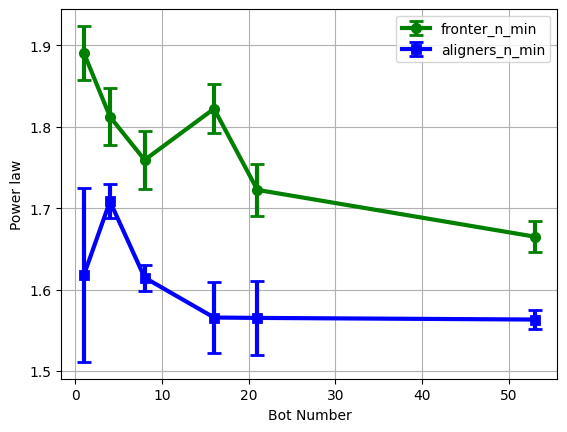

In [122]:
fronter_data=mean_data.loc[("fronter","n_min")]
fronter_data_max= mean_data.loc[("fronter","n_max")]
fronter_diff=fronter_data-fronter_data_max
aligner_data=mean_data.loc[("aligner","n_min")]
aligner_data_max=mean_data.loc[("aligner","n_max")]
aligner_diff=aligner_data-aligner_data_max
fronter_count=count_data.loc[("fronter","particle")]+1
aligner_count=count_data.loc[("aligner","particle")]+1
fig,ax = plt.subplots()
ax.errorbar(x=fronter_data.index,y=fronter_data,label='fronter_n_min',yerr=np.abs(fronter_diff.to_numpy())/np.sqrt(fronter_count),marker='o',capsize=5,color='green'
             ,markeredgewidth=2,elinewidth=3,linewidth=3)
#ax.plot(fronter_data_max.index,fronter_data_max,'-o',label='fronter_n_max')
ax.errorbar(x=aligner_data.index,y=aligner_data,label='aligners_n_min',yerr=np.abs(aligner_diff.to_numpy())/np.sqrt(aligner_count),marker='s',capsize=5,color='blue'
             ,markeredgewidth=2,elinewidth=3,linewidth=3)
#ax.plot(aligner_data_max.index,aligner_data_max,'-o',label='aligners_n_max')
ax.set_xlabel('Bot Number')
ax.set_ylabel('Power law')
ax.grid()
ax.legend()
saved_data=pd.DataFrame(data={'fronter_data': fronter_data
                              ,'fronter_data_max': fronter_data_max,'fronter_diff':fronter_diff,'aligner_data':aligner_data
                              ,'aligner_data_max':aligner_data_max,'aligner_diff':aligner_diff})
saved_data.to_csv('C:\\Users\\User\\Documents\\Eden\\locate_git_code\\production\\emsd_powerlaw_vs_Botnum_28cm.csv')
fig.savefig('C:\\Users\\User\\Documents\\Eden\\locate_git_code\\production\\emsd_powerlaw_vs_Botnum_28cm.png',bbox_inches='tight')